In [229]:
import ibis
from ibis import _
import matplotlib.pyplot as plt  
import numpy as np 
import sqlite3 as sqlite
import numpy as np                                                                                                                                                                          
from scipy.sparse import csr_matrix                                                                                                                                                         
from sklearn.decomposition import TruncatedSVD  
import scipy

In [175]:
def make_sparse(long_df, field_to_index, rows="AffiliationId", cols="FieldOfStudyId", value_col="score"): 
    # col = concepts_affiliations['AffiliationId']
    # row = 
    """Create sparse matrix from a dataframe.

    Args:
        col (np.ndarray): values for index 0 in the resulting sparse matrix
        row (np.ndarray): values for index 1 in the resulting sparse matrix.
        row_map: mapping of all possible row values to identifiers.
        data: non-zero values to to fill the sparse matrix.  

    Returns:
    (sparse matrix, map from row IDs in dataframe to row index in the sparse matrix)
    """ 

    row_values = np.array(long_df[rows])
    col_values = np.array(long_df[cols])
    data = np.array(long_df[value_col])
    print(data.shape)

    row_to_index = {id: index for index, id in enumerate(np.unique(row_values))}
    row_to_index_map = np.vectorize(row_to_index.get)

    field_to_index_map = np.vectorize(field_to_index.get)

    cols = field_to_index_map(col_values)
    rows = row_to_index_map(row_values)

    # print(cols.shape)
    # print(rows.shape)
    # print(data.shape)

    out = csr_matrix((data, (rows, cols)),
                     shape=(len(row_to_index), len(field_to_index))
                    )
    print(out.__repr__())
    return out, row_to_index
    
    
    

### To fix
- duplicate rows in fields of study?

In [68]:

db_file = "/mnt/ssd/AcademicGraph/AcademicGraph.sqlite" 
sqlite.register_adapter(np.int64, lambda val: int(val))
ibis.options.interactive = True
con = ibis.connect(db_file)
sqlite_con = sqlite.connect(database = db_file, isolation_level= None)

random_seed = 583523592352
sample_size = 1_000_000

max_level = 2
generator = np.random.default_rng(random_seed)


### Define main tables to query

In [ ]:
links_to_cng = con.table("links_to_cng")
papers = con.table("Papers")
fields_of_study = con.table("FieldsOfStudy")
paper_fields_of_study = con.table("PaperFieldsOfStudy")

query_fields_up_to_max_level = (
    fields_of_study
    .filter(
        _.Level <= max_level,
        _.Level > 0
    )
    .select(
        _.FieldOfStudyId
    )
)

### First we need to create a table with the papers we want to sample 

- `ibis.sample` does not guarantee reproducibility
- let's explicitly sample with `np.random` and a seed
- we can choose if we want to overwrite this table or not -> make command line arg

In [ ]:
selected_papers = (
    papers.
    filter(
        _.DocType.isin(["Journal","Book", "BookChapter", "Conference"]),
        _.Year >= 1985,
        _.Year <= 2020
    )
    .select("PaperId")
)

In [ ]:
all_papers = selected_papers.execute(limit=None)

In [69]:
all_papers.head()

,PaperId
0,181141341
1,1523036014
2,3046356728
3,1935107624
4,2784083118


In [46]:
subsample = all_papers.sample(n=sample_size, random_state=generator)
subsample.head()

,PaperId
49911031,2370566524
70350564,2606940148
50162113,2090109623
35223217,2028287106
39103612,2314045099


In [70]:
cursor = sqlite_con.cursor()
data_to_insert = [(x,) for x in subsample["PaperId"].values]
sql_delete = "DROP TABLE IF EXISTS selected_papers_svd"
sql_create = "CREATE TABLE selected_papers_svd (PaperId INT)"


In [71]:
cursor.execute(sql_delete)
cursor.execute(sql_create)

In [72]:
cursor.executemany("INSERT INTO selected_papers_svd (PaperId) VALUES (?)", data_to_insert)

In [73]:
cursor.execute("CREATE UNIQUE INDEX idx_paperid_selp ON selected_papers_svd(PaperId)")

In [74]:
sqlite_con.commit()

In [65]:
data_to_insert[:3]

[(np.int64(2370566524),), (np.int64(2606940148),), (np.int64(2090109623),)]

### Now load the sampled papers and their fields

In [75]:
selected_papers.head()

┏━━━━━━━━━━━━┓
┃ PaperId    ┃
┡━━━━━━━━━━━━┩
│ int64      │
├────────────┤
│  181141341 │
│ 1523036014 │
│ 3046356728 │
│ 1935107624 │
│ 2784083118 │
└────────────┘

In [77]:
selected_papers_fields = (
    selected_papers
    .join(
        paper_fields_of_study,
        "PaperId",
        how="inner"
    )
    .join(
        query_fields_up_to_max_level,
        "FieldOfStudyId",
        how="inner"
    )
    .join(
        con.table("selected_papers_svd"),
        "PaperId",
        how="inner"
    )
)
    

In [79]:
selected_papers_fields.head()

┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ PaperId    ┃ FieldOfStudyId ┃ Score    ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ int64      │ int64          │ decimal  │
├────────────┼────────────────┼──────────┤
│ 2370566524 │       89611455 │ 0.404437 │
│ 2370566524 │       98274493 │ 0.366141 │
│ 2370566524 │      181389837 │ 0.540288 │
│ 2370566524 │      185592680 │ 0.355965 │
│ 2606940148 │       15744967 │ 0.339810 │
└────────────┴────────────────┴──────────┘

In [104]:
selected_papers_fields

┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ PaperId    ┃ FieldOfStudyId ┃ Score    ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ int64      │ int64          │ decimal  │
├────────────┼────────────────┼──────────┤
│ 2370566524 │       89611455 │ 0.404437 │
│ 2370566524 │       98274493 │ 0.366141 │
│ 2370566524 │      181389837 │ 0.540288 │
│ 2370566524 │      185592680 │ 0.355965 │
│ 2606940148 │       15744967 │ 0.339810 │
│ 2606940148 │       47611674 │ 0.469222 │
│ 2606940148 │       58693492 │ 0.482417 │
│ 2606940148 │      169760540 │ 0.428821 │
│ 2606940148 │      172268261 │ 0.418724 │
│ 2606940148 │     2778818304 │ 0.425182 │
│          … │              … │        … │
└────────────┴────────────────┴──────────┘

In [105]:
papers_fields = selected_papers_fields.execute(limit=None)

AttributeError: 'Table' object has no attribute 'fetch'

In [106]:
papers_fields.head()

,PaperId,FieldOfStudyId,Score
0,2370566524,89611455,0.404436558
1,2370566524,98274493,0.3661408
2,2370566524,181389837,0.5402883
3,2370566524,185592680,0.35596478
4,2606940148,15744967,0.339810282


In [109]:
papers_fields["score"] = papers_fields["Score"].astype(np.float32)

In [110]:
papers_fields.head()

,PaperId,FieldOfStudyId,Score,score
0,2370566524,89611455,0.404436558,0.404437
1,2370566524,98274493,0.3661408,0.366141
2,2370566524,181389837,0.5402883,0.540288
3,2370566524,185592680,0.35596478,0.355965
4,2606940148,15744967,0.339810282,0.339810


### Mapping from field of study id to index

In [111]:
fields_of_study = query_fields_up_to_max_level.execute(limit=None)

In [112]:

field_to_index = {id: index for index, id in enumerate(fields_of_study['FieldOfStudyId'].unique())}
field_to_index_map = np.vectorize(field_to_index.get)


### Make sparse

TODO: why do we not have 1Mio rows?

In [176]:
papers_fields_sparse, row_to_index = make_sparse(
    papers_fields, field_to_index, "PaperId", "FieldOfStudyId", "score")

(5579567,)
<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 5579567 stored elements and shape (932508, 137499)>


### Run svd

In [125]:
def run_svd(in_matrix, n_components=50):
    # n_components = 100  # Number of dimensions to reduce to                                                                                                                                      
    svd = TruncatedSVD(n_components=n_components, random_state=42)                                                                                                                              
    embs = svd.fit_transform(in_matrix)     
    
    print(f"Original matrix shape: {in_matrix.shape}")                                                                                                                                
    print(f"Reduced matrix shape: {embs.shape}")                                                                                                                                   
    print(f"Explained variance ratio: {svd.explained_variance_ratio_.sum():.4f}")                       
    
    return svd, embs

In [7]:
svd, embs = run_svd(papers_fields_sparse, 1024)

NameError: name 'run_svd' is not defined

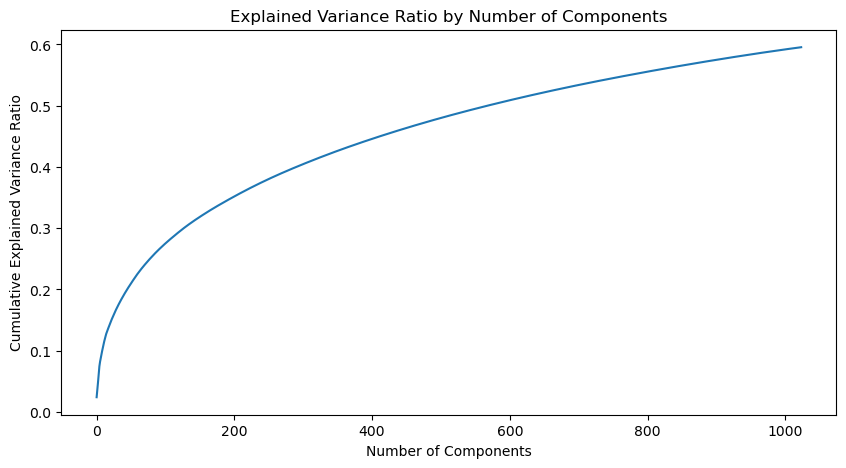

In [128]:
plt.figure(figsize=(10, 5))                                                                                                                                                                 
plt.plot(np.cumsum(svd.explained_variance_ratio_))                                                                                                                                          
plt.xlabel('Number of Components')                                                                                                                                                          
plt.ylabel('Cumulative Explained Variance Ratio')                                                                                                                                           
plt.title('Explained Variance Ratio by Number of Components')                                                                                                                               
plt.show() 

In [191]:
check_sample_size = 10_000
paper_ids_check = list(row_to_index.keys())[:check_sample_size]
paper_index_check = list(row_to_index.values())[:check_sample_size]

### Prepare sanity check: KNN classifier

In [202]:
papers_main_field = (
    con.table("PaperMainFieldsOfStudy")
    .join(
        con.table("selected_papers_svd"),
        "PaperId",
        how="inner"
    )
    .filter(_.PaperId.isin(paper_ids_check))
    .select("PaperId", "Field0")
)

In [203]:
papers_main_field.head()

┏━━━━━━━━━┳━━━━━━━━━━━┓
┃ PaperId ┃ Field0    ┃
┡━━━━━━━━━╇━━━━━━━━━━━┩
│ int64   │ int64     │
├─────────┼───────────┤
│    1163 │  15744967 │
│   20110 │  71924100 │
│   26194 │  71924100 │
│   42583 │  86803240 │
│   46216 │ 185592680 │
└─────────┴───────────┘

In [204]:
papers_main_field = papers_main_field.execute(limit=None)

In [205]:
papers_main_field.head()

,PaperId,Field0
0,1163,15744967
1,20110,71924100
2,26194,71924100
3,42583,86803240
4,46216,185592680


In [236]:
labels = papers_main_field["Field0"].values
paper_ids = papers_main_field["PaperId"].values
x_full = []
x_reduced = []


In [237]:
for paperid in paper_ids:
    row_index = row_to_index[paperid]
    x_full.append(papers_fields_sparse[row_index, :])
    x_reduced.append(embs[row_index, :])

In [238]:
x_full = scipy.sparse.vstack(x_full)
x_reduced = np.array(x_reduced)

In [239]:
x_reduced.shape

(10000, 1024)

In [240]:
x_full.shape

(10000, 137499)

In [249]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


In [253]:
n_neighbors = 50
neigh = KNeighborsClassifier(n_neighbors=n_neighbors)
# neigh_reduced = KNeighborsClassifier(n_neighbors=n_neighbors)

In [247]:
# neigh_full.fit(x_full, labels)

KNeighborsClassifier()

In [248]:
# neigh_reduced.fit(x_reduced, labels)

KNeighborsClassifier()

In [254]:
scores = cross_val_score(neigh, x_full, labels, cv=5)
scores

array([0.626 , 0.6155, 0.6035, 0.616 , 0.621 ])

In [255]:
scores = cross_val_score(neigh, x_reduced, labels, cv=5)
scores

array([0.6805, 0.678 , 0.6535, 0.6875, 0.6735])

In [264]:
papers_fields_sparse.shape
# papers_fields_sparse[0].shape

(932508, 137499)

In [277]:
a = papers_fields_sparse[0]
b = papers_fields_sparse[1]
(a @ b.T).toarray() / np.sqrt((a.power(2).sum() * b.power(2).sum()))

array([[0.23098882]], dtype=float32)

In [299]:
def cosine_similarity(m, i, j):
    a = m[i]
    b = m[j]
    ab = (a @ b.T)
    if isinstance(ab, scipy.sparse._csr.csr_matrix):
        ab = ab.toarray()
        a = a.toarray()
        b = b.toarray()

    denominator = np.power(a, 2).sum() * np.power(b, 2).sum()
    denominator = np.sqrt(denominator)
    return ab / denominator


In [345]:
n = 1_000
sim_full = []
sim_reduced = []
for _ in range(n):
    n_vectors = papers_fields_sparse.shape[0]
    i, j = np.random.choice(np.arange(n_vectors), 2)
    while i == j:
        i, j = np.random.choice(np.arange(n_vectors), 2)
    sim = cosine_similarity(papers_fields_sparse, i, j)
    sim_full.append(sim[0][0])
    sim = cosine_similarity(embs, i, j)
    sim_reduced.append(sim)

sim_full = np.array(sim_full)
sim_reduced = np.array(sim_reduced)
    

np.float32(nan)

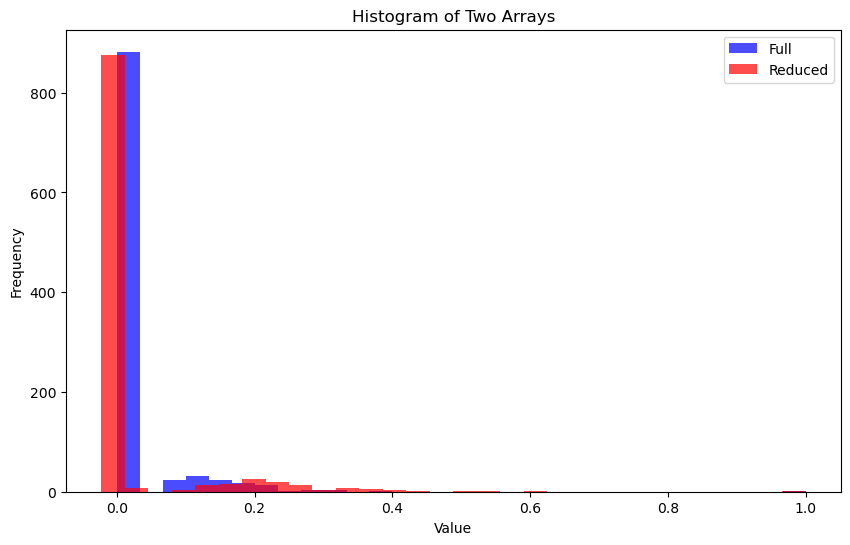

In [346]:
plt.figure(figsize=(10, 6))
plt.hist(sim_full, bins=30, alpha=0.7, color='blue', label='Full')
plt.hist(sim_reduced, bins=30, alpha=0.7, color='red', label='Reduced')
# Customize the plot
plt.title('Histogram of Two Arrays')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Add legend
plt.legend()

# Display the plot
plt.show()


In [356]:
np.max(sim_full[np.where(sim_full > 0)])

np.float32(1.0)

In [355]:
np.max(sim_reduced[np.where(sim_reduced > 0)])

np.float32(1.0000001)

In [357]:
sim_reduced.mean()

np.float32(0.02931619)

In [363]:
len(np.where(sim_reduced > 0)[0])
len(np.where(sim_full > 0)[0])

118

In [6]:
svd

NameError: name 'svd' is not defined

In [5]:
a = 3
b = 50
c = (5, 5)
(a, b, *c)

(3, 50, 5, 5)